In [1]:
import openturns.viewer as viewer
import numpy as np 
from matplotlib import pylab as plt

## Multivariate distribution

In [2]:
import openturns as ot
# Build multivariate distribution from marginals and copula
copula=ot.GumbelCopula(2.0)
marginals=[ot.Uniform(1.0, 2.0), ot.Normal(2.0, 3.0)]
distribution=ot.ComposedDistribution(marginals, copula)
# Compute first moments
mean_vector=distribution.getMean()
covariance_matrix=distribution.getCovariance()
# Compute CDF (respectively PDF)
x_cdf=distribution.computeCDF([1.5, 2.5])# x=[1.5, 2.5]
a_quantile=distribution.computeQuantile([0.9])# alpha=0.9

## Numerical integration

In [3]:
import openturns as ot
marginals=[ot.Exponential(1.0), ot.Uniform(-1.0, 1.0)]
distribution=ot.ComposedDistribution(marginals)
# Build a 2D Gaussian quadrature
marginal_size_list=[4, 4] # Number of nodes per marginal
g_quadrature=ot.GaussProductExperiment(distribution, marginal_size_list)
g_nodes, weights=g_quadrature.generateWithWeights()
# Build a Monte Carlo design
n=16 
mc_nodes=distribution.getSample(n)
# Build a quasi-Monte Carlo design
sequence=ot.HaltonSequence(2) # d=2
qmc_experiment=ot.LowDiscrepancyExperiment(sequence, distribution, n)
qmc_nodes=qmc_experiment.generate()

## Design of experiments

In [4]:
import openturns as ot
marginals=[ot.Uniform(0.0, 1.0), ot.Uniform(0.0, 1.0)]
distribution=ot.ComposedDistribution(marginals)
# Build a LHS
n=10
LHS_exp=ot.LHSExperiment(distribution, n)
LHS_design=LHS_exp.generate()
# Build an optimized LHS using L2-centered discrepancy
LHS_exp=ot.LHSExperiment(distribution, n)
SF_metric=ot.SpaceFillingC2()
SA_profile=ot.GeometricProfile(10., 0.95, 20000)
LHS_opt=ot.SimulatedAnnealingLHS(LHS_exp, SF_metric, SA_profile)
LHS_opt.generate()
LHS_design=LHS_opt.getResult().getOptimalDesign()

## Reliability analysis 

In [5]:
import openturns as ot
marginals=[ot.Normal(0.0, 1.0), ot.Exponential(1.0)]
distribution=ot.ComposedDistribution(marginals)
# Build a limit-state function and failure event
g=ot.SymbolicFunction(["x1", "x2"], ["(x1 - x2) ^ 2"])
X=ot.RandomVector(distribution)
Y=ot.CompositeRandomVector(g, X)
threshold=0.0
failure_event=ot.ThresholdEvent(Y, ot.LessOrEqual(), threshold)
# Estimate pf using FORM
starting_point=distribution.getMean()
FORM_algo=ot.FORM(ot.Cobyla(), failure_event, starting_point)
FORM_algo.run()
FORM_results=FORM_algo.getResult()
design_point=FORM_results.getStandardSpaceDesignPoint()
FORM_pf=FORM_results.getEventProbability()
# Estimate pf using Monte Carlo 
MC_exp=ot.MonteCarloExperiment()
MC_algo=ot.ProbabilitySimulationAlgorithm(failure_event, MC_exp)
MC_algo.run()
MC_results=MC_algo.getResult()
MC_pf=MC_results.getProbabilityEstimate()
MC_pf_confidence=MC_results.getConfidenceLength(0.95) # alpha=0.95
# Estimate pf using importance sampling
aux_distribution=ot.Normal(design_point, [1.0, 1.0])
standard_event=ot.StandardEvent(failure_event)
IS_exp=ot.ImportanceSamplingExperiment(aux_distribution)
IS_algo=ot.ProbabilitySimulationAlgorithm(standard_event, IS_exp)
IS_algo.run()
IS_results=IS_algo.getResult()
IS_pf=IS_results.getProbabilityEstimate()
IS_pf_confidence=IS_results.getConfidenceLength(0.95) # alpha=0.95
# Estimate pf using subset simulation
SS_algo=ot.SubsetSampling(failure_event)
SS_algo.run()
SS_results=SS_algo.getResult()
SS_pf=SS_results.getProbabilityEstimate()
SS_pf_confidence=SS_results.getConfidenceLength(0.95) # alpha=0.95

## Kriging

In [6]:
g=ot.SymbolicFunction(['x'], ['x * sin(x) + sin(6 * x)'])
x_train=ot.Uniform(0., 12.).getSample(7) # n=7
y_train=g(x_train)
basis=ot.ConstantBasisFactory(1).build() # d=1
covariance_model=ot.MaternModel([1.], 1.5)
algo=ot.KrigingAlgorithm(x_train, y_train, covariance_model, basis)
algo.run()
kriging_results=algo.getResult()
predictor=kriging_results.getMetaModel()

WRN - Warning! For coherency we set scale upper bounds = [13.842]


In [7]:
from openturns.usecases import cantilever_beam
# Load the cantilever beam model
cb=cantilever_beam.CantileverBeam()
distribution = cb.distribution
E = distribution.getMarginal(0)
F = distribution.getMarginal(1)
L = distribution.getMarginal(2)
I = distribution.getMarginal(3)

In [8]:
upper = F * L * L * L
lower = 3 * E * I
Y = upper / lower

(array([  8.,  55., 159., 239., 231., 180.,  90.,  27.,   8.,   3.]),
 array([0.11665656, 0.12943674, 0.14221692, 0.1549971 , 0.16777728,
        0.18055746, 0.19333764, 0.20611782, 0.218898  , 0.23167818,
        0.24445836]),
 <BarContainer object of 10 artists>)

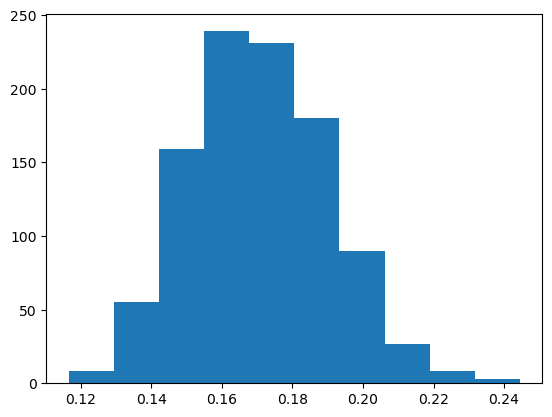

In [9]:
y_sample = Y.getSample(1000)
plt.hist(np.array(y_sample).flatten())

In [10]:
print(1-Y.computeCDF(0.3))

1.7293335119461517e-07


In [12]:
g = cb.model
X = ot.RandomVector(distribution)
Y=ot.CompositeRandomVector(g, X)
threshold=0.3
failure_event=ot.ThresholdEvent(Y, ot.Greater(), threshold)
# Estimate pf using subset simulation
SS_algo=ot.SubsetSampling(failure_event)
SS_algo.run()
SS_results=SS_algo.getResult()
SS_pf=SS_results.getProbabilityEstimate()
print(SS_pf)

4.637000000000005e-07


In [13]:
dim = 5
n = int(1e3)
distribution = ot.ComposedDistribution([ot.Uniform(0, 1)]*dim)
candidate_set = distribution.getSample(n)
# Kernel definition
ker_list = [ot.MaternModel([0.1], [1.0], 2.5)] * dim
kernel = ot.ProductCovarianceModel(ker_list)

In [14]:
# Variance-covariance matrix 
cov_matrix = kernel.discretize(candidate_set)

In [15]:
# Variance-covariance matrix 
ot.ResourceMap.SetAsString("KrigingAlgorithm-LinearAlgebra", "HMAT")
ot.ResourceMap.SetAsScalar("HMatrix-AssemblyEpsilon", 1e-5)
ot.ResourceMap.SetAsScalar("HMatrix-RecompressionEpsilon", 1e-4)
cov_matrix = kernel.discretizeHMatrix(candidate_set, ot.HMatrixParameters())

In [19]:
cov_matrix.compressionRatio()

(592000, 625000)